In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from sequential_ft_transformer.fttransformer import ft_transformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import get_model_importances


2023-12-29 09:24:23.374459: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 09:24:23.418031: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 09:24:23.722866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 09:24:23.722930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 09:24:23.786799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})

## Download Data

In [3]:
data_folder = "../data/"
seq_length = 1

In [4]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [5]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [6]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [7]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [8]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [10]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [11]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = tf.keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2023-12-29 09:24:28.135747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 09:24:28.136282: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [12]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_373053/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_373053/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [13]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [14]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

In [17]:
# sc = StandardScaler()
# X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
# X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
# test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

## Modelling Prep

In [26]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

# FTTransformer

## FT Transformer - Linear Numerical Encoding

In [27]:
EXPLANATIONS = True
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

# Pass the encoder to the model
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = x_train[NUMERIC_FEATURES].values,
    feature_unique_counts = feature_unique_counts,
    numerical_embedding_type='linear',
    seq_length=seq_length,
    embedding_dim=16,
    depth=4,
    heads=8,
    attn_dropout=0.2,
    ff_dropout=0.2,
    explainable=EXPLANATIONS
)


optimizer = tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": tf.keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})
model.compile(
    optimizer = optimizer,
    loss = loss_dict,
    metrics= metrics_dict,
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [28]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10


27/27 [==============================] - 23s 408ms/step - loss: 0.6419 - output_loss: 0.6419 - output_PR AUC: 0.2401 - val_loss: 0.5569 - val_output_loss: 0.5569 - val_output_PR AUC: 0.3075
Epoch 2/10
27/27 [==============================] - 9s 345ms/step - loss: 0.5318 - output_loss: 0.5318 - output_PR AUC: 0.3833 - val_loss: 0.4670 - val_output_loss: 0.4670 - val_output_PR AUC: 0.5554
Epoch 3/10
27/27 [==============================] - 10s 352ms/step - loss: 0.4332 - output_loss: 0.4332 - output_PR AUC: 0.5748 - val_loss: 0.4076 - val_output_loss: 0.4076 - val_output_PR AUC: 0.6379
Epoch 4/10
27/27 [==============================] - 9s 346ms/step - loss: 0.3977 - output_loss: 0.3977 - output_PR AUC: 0.6427 - val_loss: 0.3825 - val_output_loss: 0.3825 - val_output_PR AUC: 0.6948
Epoch 5/10
27/27 [==============================] - 9s 339ms/step - loss: 0.3754 - output_loss: 0.3754 - output_PR AUC: 0.6774 - val_loss: 0.3843 - val_output_loss: 0.3843 - val_output_PR AUC: 0.7081
Epoch 6/1

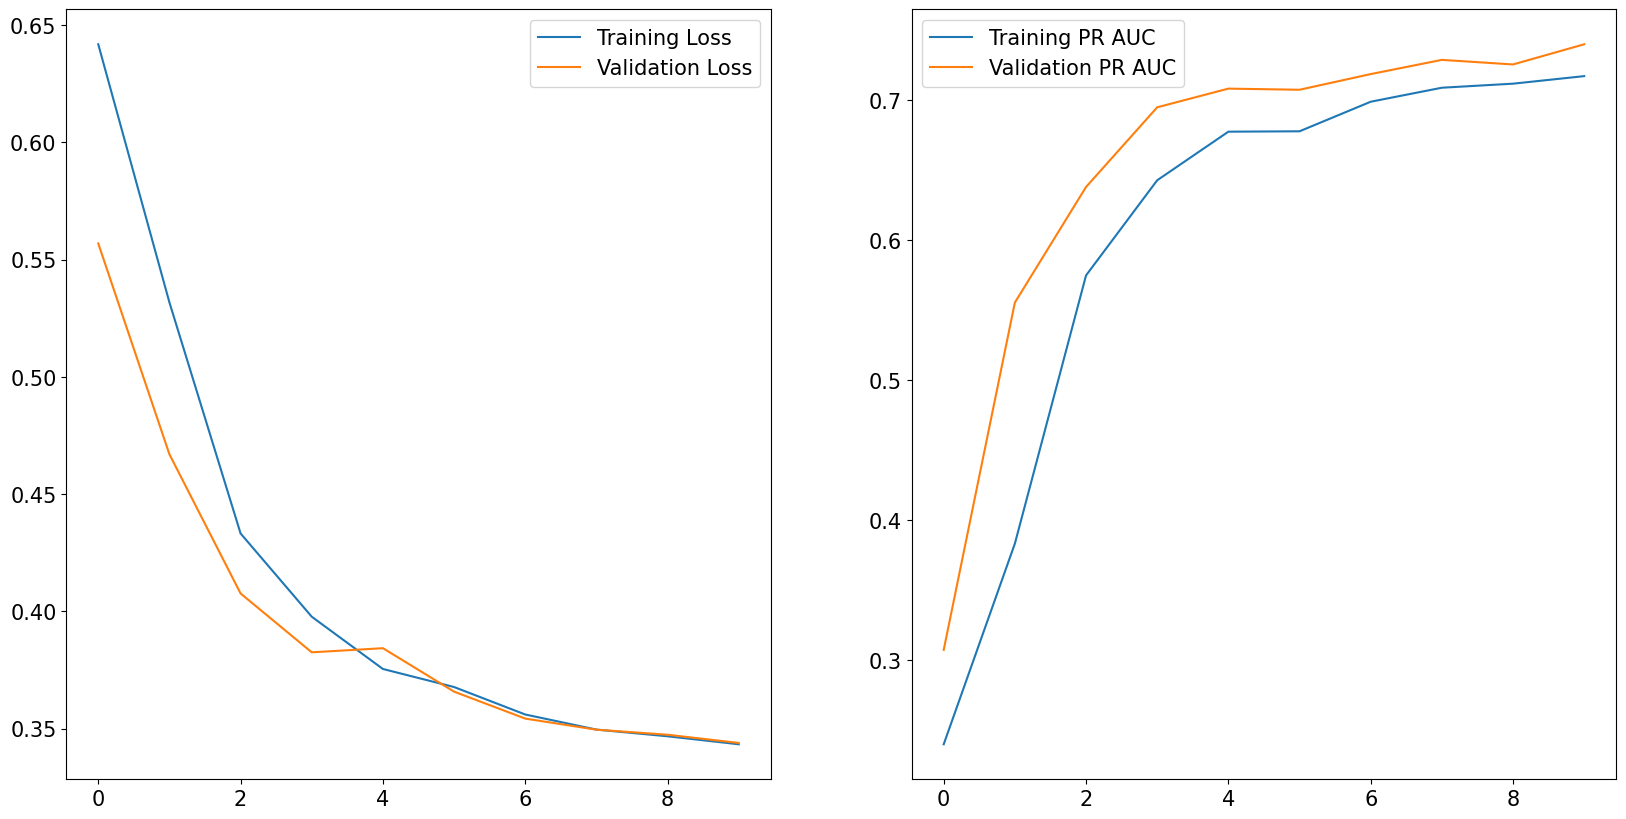

In [29]:
output_layer_name = ""
if EXPLANATIONS:
    output_layer_name = "output_"
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(hist.history['loss'], label='Training Loss')
ax[0].plot(hist.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(hist.history[f'{output_layer_name}PR AUC'], label='Training PR AUC')
ax[1].plot(hist.history[f'val_{output_layer_name}PR AUC'], label='Validation PR AUC')
ax[1].legend()

plt.show()

In [30]:
preds = model.predict(test_dataset)
print("FT-Transformer with Linear Numerical Embedding")
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

17/17 [==============================] - 3s 131ms/step
FT-Transformer with Linear Numerical Embedding
Test ROC AUC: 0.8964
Test PR AUC: 0.7238
Test Accuracy: 0.8423


## Explainability

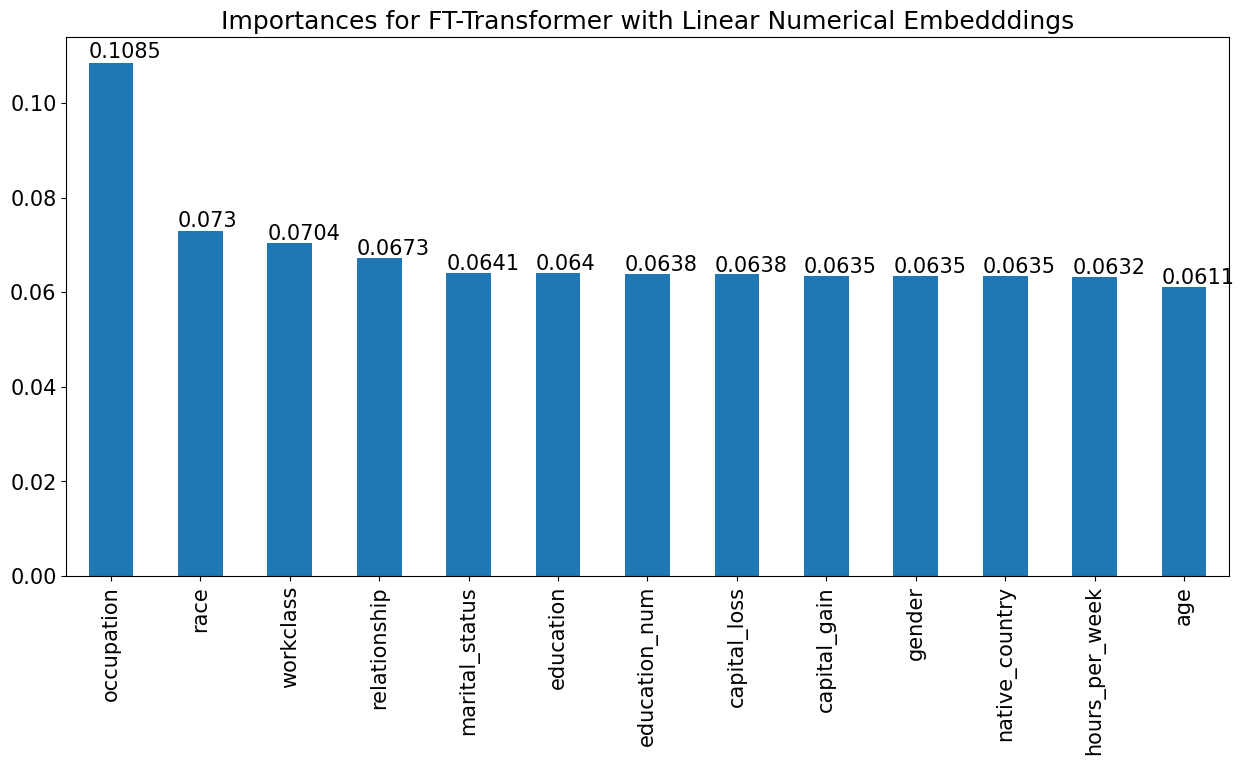

In [31]:
if 'importances' in preds.keys():
    linear_importances = preds['importances']
    linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)
    linear_total_importances = get_model_importances(
        linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
    )

In [32]:
if 'importances' in preds.keys():
    # Largest prediction
    max_idx = np.argsort(preds['output'].ravel())[-1]
    example_importance_linear = linear_importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
        test_data.iloc[max_idx, :].rename("Example Value")
    ).head(5)
    print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(preds['output'].ravel()[max_idx], 4))}")
    display(example_importance_linear)

    # Smallest one
    min_idx = np.argsort(preds['output'].ravel())[0]
    example_importance_linear = linear_importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
        test_data.iloc[min_idx, :].rename("Example Value")
    ).head(5)
    print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(preds['output'].ravel()[min_idx], 4))}")
    display(example_importance_linear)

Top 5 contributions to row 10526 which was scored 0.8895


,Importance,Example Value
race,0.097173,Asian-Pac-Islander
capital_gain,0.075307,15024.0
occupation,0.071288,Exec-managerial
gender,0.070048,Male
capital_loss,0.069224,0.0


Top 5 contributions to row 14164 which was scored 0.0169


,Importance,Example Value
occupation,0.090780,Other-service
workclass,0.072486,Private
education_num,0.069277,10.0
native_country,0.068245,United-States
race,0.068094,Other
